# Tropical Cyclone tracking

Based on the analysis done here [HECMWF](HECMWF.ipynb) we define a workflow that based on choosing the TC provides all necessary data based on ECMWF data.

First let's import the necessary python modules

numpy for array manipulation
Ipython widgets for the interactive options
matplotlib for plotting
datetime for reading the time attribute of the data
Basemap for maps
pygrib for reading the grib files provided by ECMWF
glob for filtering out the needed files within the local folder
string for string manipulations

Finaly matplotlib inline is used to display the graph within the page, otherwise it creates a separate window.

In [1]:
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
import pygrib
import glob
import os
import string
from matplotlib.colors import LinearSegmentedColormap # for custom cmap

In [2]:
%matplotlib notebook

### Cyclone tracking data

In order to view the hurricane we need to get the track from the ECMWF data. The track is provided in the name with the cyclone name and date included produced every 12 hours. These are stored in folder 'bufr' and reference the name of the tropical cyclone and are in bufr format. We can parse the folder to see the available storms for seach year and retrieve the (date,lon,lat) of the bulletin. Thus we define the function below where the name of the strom is given as input and the date and location is returned.

In [10]:
from tc import TC # see tc.py script

We can display the available TC like

In [11]:
res=TC(2016)
#res.sort()
tcnames=[]
for g in res[0]:
    if not g in tcnames:
        tcnames.append(g)

tcnames.sort()
tcnames

['01B',
 '03S',
 '04S',
 '06P',
 '07P',
 '07S',
 '08S',
 '08U',
 '09U',
 '10U',
 '12U',
 '14P',
 '14U',
 '16P',
 '17S',
 '18P',
 '20P',
 'ALEX',
 'AMOS',
 'BONNIE',
 'CORENTIN',
 'DAYA',
 'EMERAUDE',
 'EX-CORENTI',
 'EX-EMERAUD',
 'EX-FANTALA',
 'EX-URIAH',
 'FANTALA',
 'NINE',
 'ONE',
 'PALI',
 'ROANU',
 'STAN',
 'TATIANA',
 'TWO',
 'ULA',
 'URIAH',
 'VICTOR',
 'WINSTON',
 'YALO',
 'ZENA']

so now we call the first one for retriving the data. Note that this is not interactive so one has to set the values in the function arguments below. We can provide the date of interest based on the TC we investigate e.g.

In [12]:
tctimes={}
for name in tcnames:
     tctimes[name]=[]

     for g in res.T: # transpose res
          if name in g[0]:
            tctimes[name].append(g[1])
    
    
for key in tctimes:
    tctimes[key].sort()
    
tctimes

{'01B': ['2016-05-18 12:00:00', '2016-05-19 00:00:00'],
 '03S': ['2016-01-20 12:00:00', '2016-01-21 00:00:00'],
 '04S': ['2016-02-08 12:00:00', '2016-02-09 12:00:00', '2016-02-10 12:00:00'],
 '06P': ['2016-01-07 00:00:00', '2016-01-07 00:00:00'],
 '07P': ['2016-01-15 00:00:00', '2016-01-22 12:00:00'],
 '07S': ['2016-03-29 12:00:00', '2016-03-30 00:00:00', '2016-03-30 12:00:00'],
 '08S': ['2016-04-11 12:00:00'],
 '08U': ['2016-01-28 00:00:00',
  '2016-01-28 12:00:00',
  '2016-01-29 00:00:00',
  '2016-01-31 12:00:00'],
 '09U': ['2016-02-12 12:00:00', '2016-02-13 00:00:00'],
 '10U': ['2016-02-11 00:00:00', '2016-02-14 00:00:00'],
 '12U': ['2016-03-05 12:00:00', '2016-03-06 00:00:00'],
 '14P': ['2016-02-25 00:00:00', '2016-02-26 12:00:00'],
 '14U': ['2016-03-16 00:00:00'],
 '16P': ['2016-03-16 12:00:00', '2016-03-17 00:00:00'],
 '17S': ['2016-03-29 00:00:00'],
 '18P': ['2016-04-07 12:00:00'],
 '20P': ['2016-04-20 00:00:00'],
 'ALEX': ['2016-01-14 00:00:00',
  '2016-01-14 12:00:00',
  '2016

In [16]:
def getdata(yyyy=2015,mm=6,dd=3,hh=0):
    hh=np.int(hh) # This variable is passed as string and needs to become integer to be used later
    # specify date to plot.
    date = datetime.datetime(yyyy,mm,dd,hh)
    
    # set PATH of the database.
    PATHbase="/mnt/Tsunamiweb/grib/"  # Local mapping location for the above network drive
    PATH=PATHbase+"%04i/%02i/%02i/" % (yyyy,mm,dd)

    dpath=glob.glob(PATH+"*%04i%02i%02i.%02i.tropical_cyclone.grib" % (yyyy,mm,dd,hh))
   
    try:
        data = pygrib.open(dpath[0])
    except:
        print 'no available data in ', PATH
        return 
    
    pd=data[1]
    ud=data[2]
    vd=data[3]
    # read lats,lons
    # reverse latitudes so they go from south to north.
    latitudes = pd.latlons()[0].T[0][::-1]
    longitudes = pd.latlons()[1][0]
    # get sea level pressure and 10-m wind data.
    # mult slp by 0.01 to put in units of hPa
    slpin = 0.01*pd.values[:].squeeze()
    uin = ud.values[:].squeeze()
    vin = vd.values[:].squeeze()


    # add cyclic points manually (could use addcyclic function)
    slp= np.zeros((slpin.shape[0],slpin.shape[1]+1),np.float64)
    slp[:,0:-1] = slpin[::-1]; slp[:,-1] = slpin[::-1,0]
    u= np.zeros((uin.shape[0],uin.shape[1]+1),np.float64)
    u[:,0:-1] = uin[::-1]; u[:,-1] = uin[::-1,0]
    v= np.zeros((vin.shape[0],vin.shape[1]+1),np.float64)
    v[:,0:-1] = vin[::-1]; v[:,-1] = vin[::-1,0]

    longitudes=np.append(longitudes,360.)
    return date, longitudes,latitudes,slp,u,v

## TC track forecast

The ECMWF storm files are bufr files and include additional information such as pressure, wind speed at 10m and forecast. In order to access this info we need to import the python bufr modules and the bunch module for convinience. 

In [8]:
from pybufr_ecmwf.bufr import BUFRReader
from pybufr_ecmwf.raw_bufr_file import RawBUFRFile
from pybufr_ecmwf.bufr_interface_ecmwf import BUFRInterfaceECMWF

from bunch import Bunch


We can define a function that reads this files and return all necessary info, like this....

We can now create an interactive function for displaying the tracks.

Overlay the vector field from ECMWF data

In [10]:
def viewtrack(tin,stormname):
    
    trackdata=read_bufr(stormname)
    
    times=sorted(trackdata.keys())
            
    # convert time format
    dv=datetime.datetime.strptime(tin,'%Y-%m-%d %H:%M:%S') 
    index=datetime.datetime.strftime(dv,'%Y%m%d%H%M')
    
#    index=times[0]
    
    t=trackdata[index].t
    lons=trackdata[index].lons
    lats=trackdata[index].lats    
    
    # Note that
    # first lon,lat = TC center
    # second lon,lat = Lowest pressure loc & first p_msl is the value
    # third  lon,lat = maximum wind speed at 10m loc & first u10  is the value
    # then lon,lat in pairs for forecasted loc of TC center and loc of maximum wind
    # IF there is no prediction the only data are the TC center
    if t.any():
        lonp=np.append(lons[0],lons[3::2])
        latp=np.append(lats[0],lats[3::2])
        tp=np.append(0.,t)

        m1=np.abs(lonp)<180.
        m2=np.abs(latp)<90.

        if (m1 != m2).any() :
            print 'problem'
        else:
            lonp=lonp[m1]
            latp=latp[m1]
            tp=tp[m1]
        
        
        latc=np.mean(latp)
        lonc=np.mean(lonp)
    else:
        lonp=np.array([lons[0]])
        latp=np.array([lats[0]])
        tp=np.array([0.])
        
 #   llcrnrlon=np.min(lonp)-15.
 #   llcrnrlat=np.min(latp)-15.
  #  urcrnrlon=np.max(lonp)+15
 #   urcrnrlat=np.max(latp)+15

    llcrnrlon=lonp[0]-3.
    llcrnrlat=latp[0]-3.
    urcrnrlon=lonp[0]+3.
    urcrnrlat=latp[0]+3.

        
    lon_0=np.mean([llcrnrlon,urcrnrlon])
    
    
    
    
    # Lambert Conformal Conic map.
    m = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            projection='cyl',lat_1=llcrnrlat,lat_2=urcrnrlat,lon_0=-60.,
            resolution ='l',area_thresh=1000.)
    
   # get the ECMWF data 
    # first get the date from index
    dv=datetime.datetime.strptime(index,'%Y%m%d%H%M')
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=dv.year, mm=dv.month, dd=dv.day, hh=dv.hour)    
  # create figure, add axes
    fig1 = plt.figure(figsize=(8,10))
    ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,2)
        
    # define parallels and meridians to draw.
    parallels = np.arange(-80.,90,1.)
    meridians = np.arange(0.,360.,1.)

    # plot current TC center location
    xc, yc = m(lonp[0], latp[0])
    m.plot(xc,yc,'ro')
    plt.annotate('%02i' %(tp[0]),xy=(xc,yc), xytext=(10,0), textcoords='offset points', size='large',color='r')
   
    
    #plot location of minimum pressure
    
    xmp, ymp = m(lonp[1], latp[1])
    m.plot(xmp,ymp,'go')
    plt.annotate('LMP',xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='g')

    
    #plot location of maximum wind
    
    xmw, ymw = m(lonp[2], latp[2])
    m.plot(xmw,ymw,'bo')
    plt.annotate('LMW',xy=(xmw,ymw), xytext=(10,0), textcoords='offset points', size='large',color='b')

    # compute radius of maximum wind
    
    # approximate radius of earth in km
    R = 6378388  # earth's radius according to WGS 84

    lat1 = np.radians(latp[0])
    lon1 = np.radians(lonp[0])
    lat2 = np.radians(latp[2])
    lon2 = np.radians(lonp[2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    
    # plot track    
  #  xh, yh = m(lonp[1:], latp[1:])
  #  m.plot(xh,yh,'r--o')
    
  #  for label , xp, yp in zip(tp[1:],lonp[1:],latp[1:]):
  #      xmp,ymp=m(xp,yp)
  #      plt.annotate('%02i' %(label),xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='r')


    # Choose the date
    
    #cdate=datetime.datetime.strptime(times[0][:-2],'%Y%m%d%H')
    cdate=datetime.datetime.strptime(index,'%Y%m%d%H%S')
    
    
    # Read the corresponding data from the grib files  
    
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=cdate.year, mm=cdate.month, dd=cdate.day, hh=cdate.hour)
    
    print date, u.shape
    
    # Evaluate data for vector field plot
    lons, lats = np.meshgrid(longitudes,latitudes)
    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
    plt.clabel(CS1, fmt = '%03g', colors = 'k', fontsize=14)
    
    #CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)

    
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
    vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = \
    m.transform_vector(ugrid,vgrid,newlons,latitudes,31,31,returnxy=True,masked=True)
    # now plot.
    Q = m.quiver(xx,yy,uproj,vproj,scale=700)
    # make quiver key.
    qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')

    # contour of max wind
    wlevs = [20.,34.,64.,83.,96.,114.,137.] #specify color map to match NOAA's HWRF
    mapr = [(0.,'w'),(20./137.,'b'),(34./137.,'c'),(64./137.,'g'),(83./137.,'y'),(96./137.,'orange'),(114./137.,'m'),(1.,'purple')]
    cmap = LinearSegmentedColormap.from_list('mycmap',mapr)
                                        
    nm2m=1852. # 1 nautical mile to meters
    kt2ms=nm2m/3600.  # knots to m/s

    
    
    maxw=np.sqrt(uproj**2+vproj**2)/kt2ms # convert to kts for comparison
    CS2 = m.contourf(xx,yy,maxw,wlevs,cmap=cmap,extend='both',animated=True)
    cbar=m.colorbar(CS2)
    cbar.ax.set_ylabel('10m Wind (kts)')
    CS2.cmap.set_under('white')
    CS2.cmap.set_over('purple')    

    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    
    # set plot title
    ax.set_title('track of TC '+stormname+' at time '+np.str(index)+'--- RMW='+np.str(distance)+'m')
    plt.show()
        
    

Choose the TC

In [11]:
def choose(name):
    tim=tctimes[name]
    return tim

In [12]:
w=interact(choose,name=tcnames)

In [13]:
w.widget.kwargs['name']


u'KOPPU'

In [14]:
w.widget.result

['2015-10-13 12:00:00', '2015-10-14 00:00:00']

2015-10-13 12:00:00 (1280, 2561)


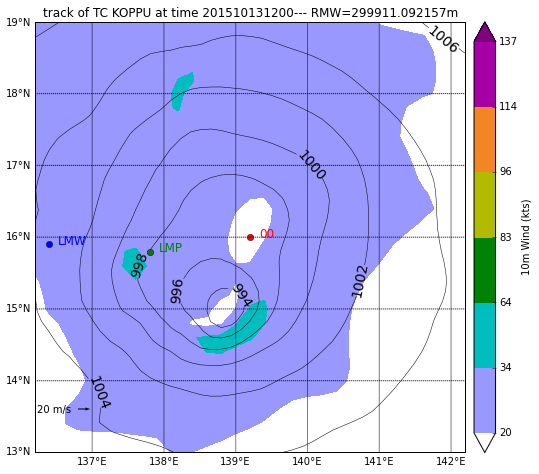

In [25]:
p=interact(viewtrack,tin=w.widget.result,stormname=w.widget.kwargs['name'])

Now we can add the data computed by our procedure (Holland parameters). This is achieved by modifying the viewtrack function to read also the data from our repository. The info from our initial storm analysis is stored in 'TCnumber/bulNo/outdata.txt' and we need to define the function that reads the file

In [18]:
def read_header(filename):

     with open(filename, 'r') as f:
       names = f.readline().split()
     f.close()
     return names
        
def readf(filename):

    var=read_header(filename) 

    dat=np.loadtxt(filename,skiprows=1)
    d=dict(zip(var,dat.T))
    return d


We need to define the unique number for this TC. At the repository path there is a correlation list. We nbeed to read it ...

In [21]:
def namelist(filename):

     with open(filename, 'r') as f:
         lines = [line.rstrip('\n\r') for line in f]
     f.close()
# create dictionary
     ndict={}
     for x in lines:
        a,b = x.split(',')
        ndict[b[:-3]]=a
     return ndict


In [22]:
flist=namelist('/mnt/web2/cycloneSurgeVM/cycloneList.txt')
flist    

{'ATSANI': '1000197',
 'CHAMPI': '1000228',
 'CHAN-HOM': '1000172',
 'CHOI-WAN': '1000222',
 'CLAUDETTE': '1000184',
 'DANNY': '1000199',
 'DOLORES': '1000182',
 'DUJUAN': '1000217',
 'EIGHT': '1000210',
 'EIGHT-C': '1000224',
 'EIGHT-E': '1000188',
 'EIGHTEEN': '1000209',
 'EIGHTEEN-E': '1000225',
 'ELA': '1000177',
 'ELEVEN': '1000220',
 'ELEVEN-E': '1000198',
 'ENRIQUE': '1000183',
 'ERIKA': '1000203',
 'ETAU': '1000209',
 'FELICIA': '1000186',
 'FIFTEEN': '1000195',
 'FIFTEEN-E': '1000208',
 'FIVE-C': '1000215',
 'FIVE-E': '1000182',
 'FOUR': '1000199',
 'FOUR-C': '1000201',
 'FOURTEEN': '1000192',
 'FOURTEEN-E': '1000206',
 'FRED': '1000205',
 'GONI': '1000196',
 'GRACE': '1000207',
 'GUILLERMO': '1000190',
 'HALOLA': '1000178',
 'HENRI': '1000210',
 'HILDA': '1000194',
 'IDA': '1000214',
 'IGNACIO': '1000202',
 'IUNE': '1000179',
 'JIMENA': '1000204',
 'JOAQUIN': '1000220',
 'KEVIN': '1000206',
 'KILO': '1000200',
 'KOPPU': '1000227',
 'KROVANH': '1000212',
 'LINDA': '1000208',
 

In [32]:
p.widget.kwargs['tin']

u'2015-10-13 12:00:00'

In [39]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [44]:
from read import bxml
tr=glob.glob('/mnt/web2/cycloneSurgeVM/{}/*'.format(flist[w.widget.kwargs['name']]))

tr.sort(key=natural_keys)

for ifile in tr:
        if os.path.isdir(ifile):
            try:
                 inp=bxml(ifile+'/bulInfo.xml')
            except IOError as e : print e
        else: break
        

inpd=np.array(inp.data.date)

dlist=[]
for a in inpd:
 dd = datetime.datetime.strptime(a,'%d %b %Y %H:%M:%S')  
 dlist.append(datetime.datetime.strftime(dd,'%Y%m%d%H%M'))
    
dlist

    


['201510130000',
 '201510130600',
 '201510131200',
 '201510131800',
 '201510140000',
 '201510140600']

In [55]:
pd=datetime.datetime.strptime(p.widget.kwargs['tin'], '%Y-%m-%d %H:%M:%S')
pdc=datetime.datetime.strftime(pd,'%Y%m%d%H%M')
pdc

'201510131200'

In [56]:
idl=dlist.index(pdc)
idl

2

In [57]:
infile='/mnt/web2/cycloneSurgeVM/{}/{}/outdata.txt'.format(flist[w.widget.kwargs['name']],idl)
hol=readf(infile)

In [58]:
hol

{'b': array([ 1.2     ,  1.2     ,  1.0907  ,  0.824172,  1.1978  ,  1.13544 ,
         1.13544 ,  1.13544 ]),
 'bias': array([        nan,         nan, -0.0587621 , -0.00019836, -0.0150802 ,
         0.0364367 ,         nan,         nan]),
 'deltap': array([   620.377,    844.402,   1027.73 ,   1447.34 ,   1848.97 ,
          4834.17 ,  11382.9  ,  11382.9  ]),
 'k': array([ 0.       ,  0.       ,  0.0177252,  0.077507 ,  0.136162 ,
         0.0806514,  0.0806514,  0.0806514]),
 'rmax': array([ 20000. ,  20000. ,  34605.1,  44277.9,  36080.8,  19627.5,
         19627.5,  19627.5]),
 'rmse': array([      nan,       nan,  0.665449,  0.129562,  0.299311,  0.451404,
              nan,       nan]),
 'time': array([   0.,   12.,   24.,   36.,   48.,   72.,   96.,  120.]),
 'vmax': array([ 15.432,  18.004,  20.576,  25.72 ,  33.436,  48.868,  64.3  ,  64.3  ]),
 'vmax0': array([  7.09872,   8.75194,  18.9363 ,  19.5343 ,  26.6171 ,  41.9031 ,
         56.7505 ,  57.2517 ]),
 'vtr': array([ 8

in order to define a circle with specific radius we use these functions (see http://www.geophysique.be/2011/02/20/matplotlib-basemap-tutorial-09-drawing-circles/)

In [59]:
def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.
 
    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")
 
    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)
 
    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):
 
        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu
 
    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi    
 
    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)
 
    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi
 
    return (glon2, glat2, baz)
 
def equi(centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
 
    #~ m.plot(X,Y,**kwargs) #Should work, but doesn't...
    return X,Y

In [60]:
hol
hol['xhc'][0], hol['yhc'][0], hol['rmax'][0]

(140.09999999999999, 15.699999999999999, 20000.0)

In [61]:
def viewtrack2(tin,stormname):
    
    
    trackdata=read_bufr(stormname)
    
    times=sorted(trackdata.keys())
            
    
        
    # convert time format
    dv=datetime.datetime.strptime(tin,'%Y-%m-%d %H:%M:%S') 
    index=datetime.datetime.strftime(dv,'%Y%m%d%H%M')
    
#    index=times[0]
    
    t=trackdata[index].t
    lons=trackdata[index].lons
    lats=trackdata[index].lats    
    
    # Note that
    # first lon,lat = TC center
    # second lon,lat = Lowest pressure loc & first p_msl is the value
    # third  lon,lat = maximum wind speed at 10m loc & first u10  is the value
    # then lon,lat in pairs for forecasted loc of TC center and loc of maximum wind
    # IF there is no prediction the only data are the TC center
    if t.any():
        lonp=np.append(lons[0],lons[3::2])
        latp=np.append(lats[0],lats[3::2])
        tp=np.append(0.,t)

        m1=np.abs(lonp)<180.
        m2=np.abs(latp)<90.

        if (m1 != m2).any() :
            print 'problem'
        else:
            lonp=lonp[m1]
            latp=latp[m1]
            tp=tp[m1]
        
        
        latc=np.mean(latp)
        lonc=np.mean(lonp)
    else:
        lonp=np.array([lons[0]])
        latp=np.array([lats[0]])
        tp=np.array([0.])
        
 #   llcrnrlon=np.min(lonp)-15.
 #   llcrnrlat=np.min(latp)-15.
  #  urcrnrlon=np.max(lonp)+15
 #   urcrnrlat=np.max(latp)+15

    llcrnrlon=lonp[0]-3.
    llcrnrlat=latp[0]-3.
    urcrnrlon=lonp[0]+3.
    urcrnrlat=latp[0]+3.

        
    lon_0=np.mean([llcrnrlon,urcrnrlon])
    
    
    
    
    # Cyl map.
    m = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            projection='cyl',lat_1=llcrnrlat,lat_2=urcrnrlat,lon_0=-60.,
            resolution ='l',area_thresh=1000.)
    
   # get the ECMWF data 
    # first get the date from index
    dv=datetime.datetime.strptime(index,'%Y%m%d%H%M')
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=dv.year, mm=dv.month, dd=dv.day, hh=dv.hour)    
  # create figure, add axes
    fig1 = plt.figure(figsize=(8,10))
    ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,2)
    
    
  # plot current TC center location from bufr data
    xc, yc = m(lonp[0], latp[0])
    m.plot(xc,yc,'ro')
    plt.annotate('%02i' %(tp[0]),xy=(xc,yc), xytext=(10,0), textcoords='offset points', size='large',color='r')
   
    
    #plot location of minimum pressure from bufr data
    
    xmp, ymp = m(lonp[1], latp[1])
    m.plot(xmp,ymp,'go')
    plt.annotate('LMP',xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='g')

    
    #plot location of maximum wind from bufr data
    
    xmw, ymw = m(lonp[2], latp[2])
    m.plot(xmw,ymw,'bo')
    plt.annotate('LMW',xy=(xmw,ymw), xytext=(10,0), textcoords='offset points', size='large',color='b')

        
    # define parallels and meridians to draw.
    parallels = np.arange(-80.,90,1.)
    meridians = np.arange(0.,360.,1.)

     
    # print the TC center location and radius of max. wind from our model (Holland)
    xhc, yhc = m(hol['xhc'][0], hol['yhc'][0])
    m.plot(xhc,yhc,'rx')
    plt.annotate('%02i' %(0),xy=(xhc,yhc), xytext=(10,0), textcoords='offset points', size='large',color='r')

     
    # compute radius of maximum wind
    
    # approximate radius of earth in km
    R = 6378388  # earth's radius according to WGS 84

    lat1 = np.radians(latp[0])
    lon1 = np.radians(lonp[0])
    lat2 = np.radians(latp[2])
    lon2 = np.radians(lonp[2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    #plot radius of maximum wind from holland parameters
    
    rx,ry=equi(hol['xhc'][0], hol['yhc'][0], hol['rmax'][0]/1000.)
    rpx,rpy=m(rx,ry)
    m.plot(rpx,rpy,'r--',lw=2)

    
    # plot track    
  #  xh, yh = m(lonp[1:], latp[1:])
  #  m.plot(xh,yh,'r--o')
    
  #  for label , xp, yp in zip(tp[1:],lonp[1:],latp[1:]):
  #      xmp,ymp=m(xp,yp)
  #      plt.annotate('%02i' %(label),xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='r')


    # Choose the date
    
    #cdate=datetime.datetime.strptime(times[0][:-2],'%Y%m%d%H')
    cdate=datetime.datetime.strptime(index,'%Y%m%d%H%S')
    
    
    # Read the corresponding data from the grib files  
    
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=cdate.year, mm=cdate.month, dd=cdate.day, hh=cdate.hour)
    
    print date
    
    # Evaluate data for vector field plot
    lons, lats = np.meshgrid(longitudes,latitudes)
    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
    plt.clabel(CS1, fmt = '%03g', colors = 'k', fontsize=14)
    
    #CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)

    
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
    vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = \
    m.transform_vector(ugrid,vgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    #plot location of maximum wind from u, v data
    totv=np.sqrt(uproj**2+vproj**2)
    i,j = np.unravel_index(totv.argmax(), totv.shape)
    mwx, mwy=xx[i,j],yy[i,j]
    
    m.plot(mwx,mwy,'bx')
    plt.annotate('LMW',xy=(mwx,mwy), xytext=(0,10), textcoords='offset points', size='large',color='b')

    #plot location of minimum pressure from slp data
    slpgrid,newlons = shiftgrid(180.,slp,longitudes,start=False)
    slp_proj,xx,yy = \
    m.transform_scalar(slpgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    i,j = np.unravel_index(slp_proj.argmin(), slp_proj.shape)
    
    mpx, mpy=xx[i,j],yy[i,j]
       
    m.plot(mpx,mpy,'gx')
    plt.annotate('LMP',xy=(mpx,mpy), xytext=(0,10), textcoords='offset points', size='xx-large',color='g')


    # contour of max wind
    wlevs = [20.,34.,64.,83.,96.,114.,137.] #specify color map to match NOAA's HWRF
    mapr = [(0.,'w'),(20./137.,'b'),(34./137.,'c'),(64./137.,'g'),(83./137.,'y'),(96./137.,'orange'),(114./137.,'m'),(1.,'purple')]
    cmap = LinearSegmentedColormap.from_list('mycmap',mapr)
                                        
    nm2m=1852. # 1 nautical mile to meters
    kt2ms=nm2m/3600.  # knots to m/s

    
    
    
    maxw=np.sqrt(uproj**2+vproj**2)/kt2ms # convert to kts for comparison# 
    CS2 = m.contourf(xx,yy,maxw,wlevs,cmap=cmap,extend='both',animated=True)
    cbar=m.colorbar(CS2)
    cbar.ax.set_ylabel('10m Wind (kts)')
    CS2.cmap.set_under('white')
    CS2.cmap.set_over('purple')    


    # now plot vectors.
    Q = m.quiver(xx,yy,uproj,vproj,scale=700)
    # make quiver key.
    qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')

    
    
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    
    # set plot title
    ax.set_title('track of TC '+stormname+' at time '+np.str(index)+'--- RMW='+np.str(distance)+'m')
    plt.show()
    return slp_proj
    

2015-10-13 12:00:00


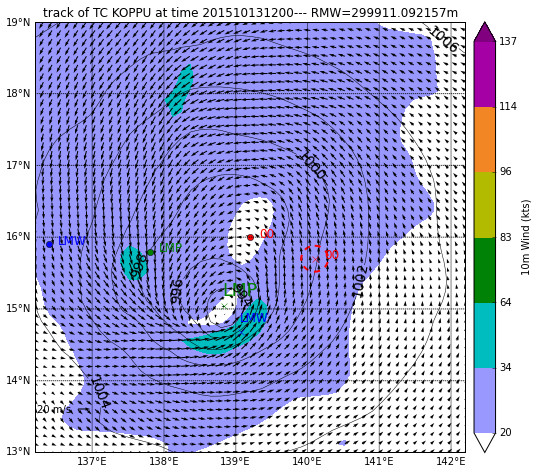

In [62]:
ppr=interact(viewtrack2,tin=w.widget.result,stormname=w.widget.kwargs['name'])

As one can see above the bufr files give coarse grid ensemble data and deviate from the HR data significantly. We will not included then here directly. (We can use them later for the cone?)

In [63]:
def viewtrack3(tin,stormname):
       
    trackdata=read_bufr(stormname)
    
    times=sorted(trackdata.keys())
                
        
    # convert time format
    dv=datetime.datetime.strptime(tin,'%Y-%m-%d %H:%M:%S') 
    index=datetime.datetime.strftime(dv,'%Y%m%d%H%M')

    
#    index=times[0]
    
    t=trackdata[index].t
    lons=trackdata[index].lons
    lats=trackdata[index].lats    
    
    # Note that
    # first lon,lat = TC center
    # second lon,lat = Lowest pressure loc & first p_msl is the value
    # third  lon,lat = maximum wind speed at 10m loc & first u10  is the value
    # then lon,lat in pairs for forecasted loc of TC center and loc of maximum wind
    # IF there is no prediction the only data are the TC center
    if t.any():
        lonp=np.append(lons[0],lons[3::2])
        latp=np.append(lats[0],lats[3::2])
        tp=np.append(0.,t)

        m1=np.abs(lonp)<180.
        m2=np.abs(latp)<90.

        if (m1 != m2).any() :
            print 'problem'
        else:
            lonp=lonp[m1]
            latp=latp[m1]
            tp=tp[m1]
        
        
        latc=np.mean(latp)
        lonc=np.mean(lonp)
    else:
        lonp=np.array([lons[0]])
        latp=np.array([lats[0]])
        tp=np.array([0.])
        
 #   llcrnrlon=np.min(lonp)-15.
 #   llcrnrlat=np.min(latp)-15.
  #  urcrnrlon=np.max(lonp)+15
 #   urcrnrlat=np.max(latp)+15

    llcrnrlon=lonp[0]-5.
    llcrnrlat=latp[0]-5.
    urcrnrlon=lonp[0]+5.
    urcrnrlat=latp[0]+5.

        
    lon_0=np.mean([llcrnrlon,urcrnrlon])
    
    
    
    
    # Cyl map.
    m = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            projection='cyl',lat_1=llcrnrlat,lat_2=urcrnrlat,lon_0=-60.,
            resolution ='l',area_thresh=1000.)
    
   # get the ECMWF data 
    # first get the date from index
    dv=datetime.datetime.strptime(index,'%Y%m%d%H%M')
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=dv.year, mm=dv.month, dd=dv.day, hh=dv.hour)    
  # create figure, add axes
    fig1 = plt.figure(figsize=(8,10))
    ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,2)
    
            
    # define parallels and meridians to draw.
    parallels = np.arange(-80.,90,1.)
    meridians = np.arange(0.,360.,1.)

     
    # print the TC center location and radius of max. wind from our model (Holland)
    xhc, yhc = m(hol['xhc'][0], hol['yhc'][0])
    m.plot(xhc,yhc,'rx')
    plt.annotate('%02i' %(0),xy=(xhc,yhc), xytext=(10,0), textcoords='offset points', size='large',color='r')

     

    #plot radius of maximum wind from holland parameters
    
    rx,ry=equi(hol['xhc'][0], hol['yhc'][0], hol['rmax'][0]/1000.)
    rpx,rpy=m(rx,ry)
    m.plot(rpx,rpy,'r--',lw=2)

    
    # plot track    
  #  xh, yh = m(lonp[1:], latp[1:])
  #  m.plot(xh,yh,'r--o')
    
  #  for label , xp, yp in zip(tp[1:],lonp[1:],latp[1:]):
  #      xmp,ymp=m(xp,yp)
  #      plt.annotate('%02i' %(label),xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='r')


    # Choose the date
    
    #cdate=datetime.datetime.strptime(times[0][:-2],'%Y%m%d%H')
    cdate=datetime.datetime.strptime(index,'%Y%m%d%H%S')
    
    
    # Read the corresponding data from the grib files  
    
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=cdate.year, mm=cdate.month, dd=cdate.day, hh=cdate.hour)
    
    print date
    
    # Evaluate data for vector field plot
    lons, lats = np.meshgrid(longitudes,latitudes)
    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
    plt.clabel(CS1, fmt = '%03g', colors = 'k', fontsize=14)
    
    #CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)

    
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
    vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = \
    m.transform_vector(ugrid,vgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    #plot location of maximum wind from u, v data
    totv=np.sqrt(uproj**2+vproj**2)
    i,j = np.unravel_index(totv.argmax(), totv.shape)
    mwx, mwy=xx[i,j],yy[i,j]
    
    m.plot(mwx,mwy,'bo', markersize=15)
    plt.annotate('LMW',xy=(mwx,mwy), xytext=(0,10), textcoords='offset points', size='xx-large',color='b')

    #plot location of minimum pressure from slp data
    slpgrid,newlons = shiftgrid(180.,slp,longitudes,start=False)
    slp_proj,xx,yy = \
    m.transform_scalar(slpgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    i,j = np.unravel_index(slp_proj.argmin(), slp_proj.shape)
    
    mpx, mpy=xx[i,j],yy[i,j]
       
    m.plot(mpx,mpy,'go', markersize=15,)
    plt.annotate('LMP',xy=(mpx,mpy), xytext=(0,10), textcoords='offset points', size='xx-large',color='g')


    # contour of max wind
    wlevs = [20.,34.,64.,83.,96.,114.,137.] #specify color map to match NOAA's HWRF
    mapr = [(0.,'w'),(20./137.,'b'),(34./137.,'c'),(64./137.,'g'),(83./137.,'y'),(96./137.,'orange'),(114./137.,'m'),(1.,'purple')]
    cmap = LinearSegmentedColormap.from_list('mycmap',mapr)
                                        
    nm2m=1852. # 1 nautical mile to meters
    kt2ms=nm2m/3600.  # knots to m/s

    
    
    
    maxw=np.sqrt(uproj**2+vproj**2)/kt2ms # convert to kts for comparison# 
    CS2 = m.contourf(xx,yy,maxw,wlevs,cmap=cmap,extend='both',animated=True)
    cbar=m.colorbar(CS2)
    cbar.ax.set_ylabel('10m Wind (kts)')
    CS2.cmap.set_under('white')
    CS2.cmap.set_over('purple') 
    
    lonpt, latpt = m(mpx,mpy,inverse=True)
    # compute radius of maximum wind from ECMWF minimum pressure to maxinum wind
    
    # approximate radius of earth in km
    R = 6378388  # earth's radius according to WGS 84

    lat1 = np.radians(mpx)
    lon1 = np.radians(mpy)
    lat2 = np.radians(mwx)
    lon2 = np.radians(mwy)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    
    r2x,r2y=equi(lonpt, latpt, distance/1000.)
    r2px,r2py=m(r2x,r2y)
    m.plot(r2px,r2py,'r--',lw=5)

    # now plot vectors.
#    Q = m.quiver(xx,yy,uproj,vproj,scale=700)
    # make quiver key.
#    qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')

    #xx, yy = m.makegrid(v.shape[1], v.shape[0], returnxy=True)[2:4]
    speed = np.sqrt(uproj*uproj + vproj*vproj)
    S = m.streamplot(xx,yy,uproj,vproj,color=speed, linewidth=0.1*speed)

    
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    
    # set plot title
    ax.set_title('track of TC '+stormname+' at time '+np.str(index)+'\n RMW_ECMWF='+np.str(distance)+'m  RMW_Holland='+np.str(hol['rmax'][0])+'m')
    plt.show()
    return slp_proj
    

2015-10-13 12:00:00


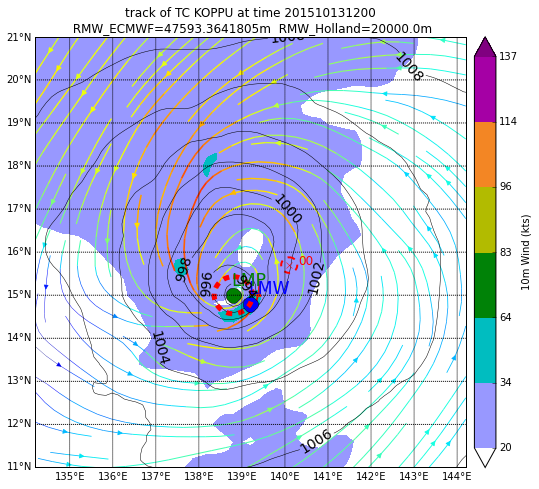

In [64]:
ppr=interact(viewtrack3,tin=w.widget.result,stormname=w.widget.kwargs['name'])

Version where reading consistently our data is implemented

Routine to read xml data from our database

In [65]:
import xmltodict
from bunch import *

def bxml(doc):

        with open(doc) as fd:
                obj = xmltodict.parse(fd.read())

        return bunchify(obj)



In [66]:
def viewtrack4(tin,stormname):
    
    
    trackdata=read_bufr(stormname)

    folder=flist[stormname]
    
    # get the bul folders in storm folder
    
    tr=glob.glob('/mnt/web2/cycloneSurgeVM/{}/*'.format(folder))
    
    bul={}
    for ifile in tr:
        if os.path.isdir(ifile):
            o=ifile.split('/')[-1]
            try:
              te=np.int(o)
              bul[o]= ifile # store only number folders
            except: pass
    
    bulmax = np.array(bul.keys()).astype(int).max() # find the maximum bulletin
    
    pathf='/mnt/web2/cycloneSurgeVM/{}/'.format(folder)+bulmax.astype(str)+'/bulInfo.xml'
    inp=bxml(pathf)
    
    
    timesJRC=np.array(inp.data.date)
    # convert time format
    dvJRC=[]
    for j in timesJRC:
       a=datetime.datetime.strptime(j,'%d %b %Y %H:%M:%S')
       dvJRC.append(datetime.datetime.strftime(a,'%Y%m%d%H%M')) 
        
    # convert time format
    dv=datetime.datetime.strptime(tin,'%Y-%m-%d %H:%M:%S') 
    index=datetime.datetime.strftime(dv,'%Y%m%d%H%M')

    
#    index=times[0]
    
    t=trackdata[index].t
    lons=trackdata[index].lons
    lats=trackdata[index].lats    
    
    # Note that
    # first lon,lat = TC center
    # second lon,lat = Lowest pressure loc & first p_msl is the value
    # third  lon,lat = maximum wind speed at 10m loc & first u10  is the value
    # then lon,lat in pairs for forecasted loc of TC center and loc of maximum wind
    # IF there is no prediction the only data are the TC center
    if t.any():
        lonp=np.append(lons[0],lons[3::2])
        latp=np.append(lats[0],lats[3::2])
        tp=np.append(0.,t)

        m1=np.abs(lonp)<180.
        m2=np.abs(latp)<90.

        if (m1 != m2).any() :
            print 'problem'
        else:
            lonp=lonp[m1]
            latp=latp[m1]
            tp=tp[m1]
        
        
        latc=np.mean(latp)
        lonc=np.mean(lonp)
    else:
        lonp=np.array([lons[0]])
        latp=np.array([lats[0]])
        tp=np.array([0.])
        
 #   llcrnrlon=np.min(lonp)-15.
 #   llcrnrlat=np.min(latp)-15.
  #  urcrnrlon=np.max(lonp)+15
 #   urcrnrlat=np.max(latp)+15

    llcrnrlon=lonp[0]-5.
    llcrnrlat=latp[0]-5.
    urcrnrlon=lonp[0]+5.
    urcrnrlat=latp[0]+5.

        
    lon_0=np.mean([llcrnrlon,urcrnrlon])
    
    
    
    
    # Cyl map.
    m = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            projection='cyl',lat_1=llcrnrlat,lat_2=urcrnrlat,lon_0=-60.,
            resolution ='l',area_thresh=1000.)
    
   # get the ECMWF data 
    # first get the date from index
    dv=datetime.datetime.strptime(index,'%Y%m%d%H%M')
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=dv.year, mm=dv.month, dd=dv.day, hh=dv.hour)    
  # create figure, add axes
    fig1 = plt.figure(figsize=(8,10))
    ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,2)
    
            
    # define parallels and meridians to draw.
    parallels = np.arange(-80.,90,1.)
    meridians = np.arange(0.,360.,1.)

    
    #read Holland outdata.txt
    hol=[]
    
    if index in dvJRC: 
        bulNo=np.where(np.array(dvJRC)==index)[0][0]
        bulNumber = inp.data.advNo[bulNo]
        infile='/mnt/web2/cycloneSurgeVM/{}/{}/outdata.txt'.format(folder,bulNumber)
        try:
            hol=readf(infile)
        except e:
            print e

    # print the TC center location and radius of max. wind from our model (Holland)
        xhc, yhc = m(hol['xhc'][0], hol['yhc'][0])
        m.plot(xhc,yhc,'rx')
        plt.annotate('%02i' %(0),xy=(xhc,yhc), xytext=(10,0), textcoords='offset points', size='large',color='r')

     

    #plot radius of maximum wind from holland parameters
    
        rx,ry=equi(hol['xhc'][0], hol['yhc'][0], hol['rmax'][0]/1000.)
        rpx,rpy=m(rx,ry)
        m.plot(rpx,rpy,'r--',lw=2)


    # plot the rmw per quadrant from bulletin
    
    
    
    # plot track    
  #  xh, yh = m(lonp[1:], latp[1:])
  #  m.plot(xh,yh,'r--o')
    
  #  for label , xp, yp in zip(tp[1:],lonp[1:],latp[1:]):
  #      xmp,ymp=m(xp,yp)
  #      plt.annotate('%02i' %(label),xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='r')


    # Choose the date
    
    #cdate=datetime.datetime.strptime(times[0][:-2],'%Y%m%d%H')
    cdate=datetime.datetime.strptime(index,'%Y%m%d%H%S')
    
    
    # Read the corresponding data from the grib files  
    
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=cdate.year, mm=cdate.month, dd=cdate.day, hh=cdate.hour)
    
    print date
    
    # Evaluate data for vector field plot
    lons, lats = np.meshgrid(longitudes,latitudes)
    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
    plt.clabel(CS1, fmt = '%03g', colors = 'k', fontsize=14)
    
    #CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)

    
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
    vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = \
    m.transform_vector(ugrid,vgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    #plot location of maximum wind from u, v data
    totv=np.sqrt(uproj**2+vproj**2)
    i,j = np.unravel_index(totv.argmax(), totv.shape)
    mwx, mwy=xx[i,j],yy[i,j]
    
    m.plot(mwx,mwy,'bo', markersize=15)
    plt.annotate('LMW',xy=(mwx,mwy), xytext=(0,10), textcoords='offset points', size='xx-large',color='b')

    #plot location of minimum pressure from slp data
    slpgrid,newlons = shiftgrid(180.,slp,longitudes,start=False)
    slp_proj,xx,yy = \
    m.transform_scalar(slpgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    i,j = np.unravel_index(slp_proj.argmin(), slp_proj.shape)
    
    mpx, mpy=xx[i,j],yy[i,j]
       
    m.plot(mpx,mpy,'go', markersize=15,)
    plt.annotate('LMP',xy=(mpx,mpy), xytext=(0,10), textcoords='offset points', size='xx-large',color='g')


    # contour of max wind
    wlevs = [20.,34.,64.,83.,96.,114.,137.] #specify color map to match NOAA's HWRF
    mapr = [(0.,'w'),(20./137.,'b'),(34./137.,'c'),(64./137.,'g'),(83./137.,'y'),(96./137.,'orange'),(114./137.,'m'),(1.,'purple')]
    cmap = LinearSegmentedColormap.from_list('mycmap',mapr)
                                        
    nm2m=1852. # 1 nautical mile to meters
    kt2ms=nm2m/3600.  # knots to m/s

    
    
    
    maxw=np.sqrt(uproj**2+vproj**2)/kt2ms # convert to kts for comparison# 
    CS2 = m.contourf(xx,yy,maxw,wlevs,cmap=cmap,extend='both',animated=True)
    cbar=m.colorbar(CS2)
    cbar.ax.set_ylabel('10m Wind (kts)')
    CS2.cmap.set_under('white')
    CS2.cmap.set_over('purple') 
    
    lonpt, latpt = m(mpx,mpy,inverse=True)
    lonwt, latwt = m(mwx,mwy,inverse=True)

    # compute radius of maximum wind from ECMWF minimum pressure to maxinum wind
    
    # approximate radius of earth in km
    R = 6378388  # earth's radius according to WGS 84

    lat1 = np.radians(latpt)
    lon1 = np.radians(lonpt)
    lat2 = np.radians(latwt)
    lon2 = np.radians(lonwt)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    
    r2x,r2y=equi(lonpt, latpt, distance/1000.)
    r2px,r2py=m(r2x,r2y)
    m.plot(r2px,r2py,'b--',lw=2)

    # now plot vectors.
#    Q = m.quiver(xx,yy,uproj,vproj,scale=700)
    # make quiver key.
#    qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')

    #xx, yy = m.makegrid(v.shape[1], v.shape[0], returnxy=True)[2:4]
    speed = np.sqrt(uproj*uproj + vproj*vproj)
    S = m.streamplot(xx,yy,uproj,vproj,color=speed, linewidth=0.1*speed)

    
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    
    # set plot title
    if hol : 
        rmwh=np.str(hol['rmax'][0])
    else:
        rmwh=''
    ax.set_title('track of TC '+stormname+' at time '+np.str(index)+'\n RMW_ECMWF='+np.str(distance)+'m  RMW_Holland='+rmwh+'m')
    plt.show()
    
    

2015-10-13 12:00:00


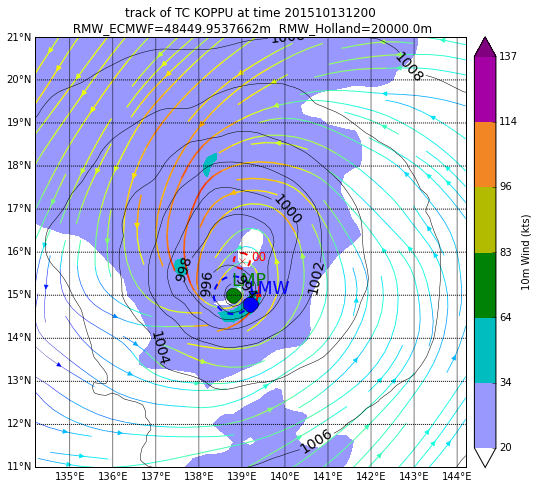

In [67]:
ppr=interact(viewtrack4,tin=w.widget.result,stormname=w.widget.kwargs['name'])

In [68]:
def rmw(radii34,radii50,radii64):
#def rmw(fig1,loc,radii):

#plot polar plot with the radius of maximum wind for each quadrant from bulletin
    theta = np.linspace(0.0, 2 * np.pi, 4, endpoint=False)

    #radii = [12,23,34,54]
    width = np.pi / 2

    ax = plt.subplot(111, polar=True)
    #ax = fig1.add_axes(loc, polar=True)

    bars = ax.bar(theta, radii34, width=width, bottom=0.0, fill=False, edgecolor=['r'], label='64 kt')
    bars = ax.bar(theta, radii50, width=width, bottom=0.0, fill=False, edgecolor=['orange'],label='50 kt')
    bars = ax.bar(theta, radii64, width=width, bottom=0.0, fill=False, edgecolor=['g'],label='34 kt')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    ax.patch.set_alpha(0.)
    
    ax.spines['polar'].set_visible(False)
        
    # Use custom colors and opacity        
 #   labels = ['64 kt','50 kt','36 kt']
  #  for r, bar, ll in zip(theta, bars, labels):
      #bar.set_facecolor(plt.cm.jet(r / np.pi / 2))
  #    bar.set_alpha(0.5)
  #    bar.set_label(ll)
      

    ax.legend(loc = 'upper right', bbox_to_anchor = (1.5, 1.0))    
    plt.show()

In [ ]:
rmw([12,23,34,54],[32,43,54,64],[72,73,74,84])

View the input data from the bulletin

In [92]:
def viewbul(tin,stormname):
    
    
    trackdata=read_bufr(stormname)

    folder=flist[stormname]
    
    # get the bul folders in storm folder
    
    tr=glob.glob('/mnt/web2/cycloneSurgeVM/{}/*'.format(folder))
    
    bul={}
    for ifile in tr:
        if os.path.isdir(ifile):
            o=ifile.split('/')[-1]
            try:
              te=np.int(o)
              bul[o]= ifile # store only number folders
            except: pass
    
    bulmax = np.array(bul.keys()).astype(int).max() # find the maximum bulletin
    
    pathf='/mnt/web2/cycloneSurgeVM/{}/'.format(folder)+bulmax.astype(str)+'/bulInfo.xml'
    inp=bxml(pathf)
    
    
    timesJRC=np.array(inp.data.date)
    # convert time format
    dvJRC=[]
    for j in timesJRC:
       a=datetime.datetime.strptime(j,'%d %b %Y %H:%M:%S')
       dvJRC.append(datetime.datetime.strftime(a,'%Y%m%d%H%M')) 
        
    # convert time format
    dv=datetime.datetime.strptime(tin,'%Y-%m-%d %H:%M:%S') 
    index=datetime.datetime.strftime(dv,'%Y%m%d%H%M')

    
#    index=times[0]
    
    t=trackdata[index].t
    lons=trackdata[index].lons
    lats=trackdata[index].lats    
    
    # Note that
    # first lon,lat = TC center
    # second lon,lat = Lowest pressure loc & first p_msl is the value
    # third  lon,lat = maximum wind speed at 10m loc & first u10  is the value
    # then lon,lat in pairs for forecasted loc of TC center and loc of maximum wind
    # IF there is no prediction the only data are the TC center
    if t.any():
        lonp=np.append(lons[0],lons[3::2])
        latp=np.append(lats[0],lats[3::2])
        tp=np.append(0.,t)

        m1=np.abs(lonp)<180.
        m2=np.abs(latp)<90.

        if (m1 != m2).any() :
            print 'problem'
        else:
            lonp=lonp[m1]
            latp=latp[m1]
            tp=tp[m1]
        
        
        latc=np.mean(latp)
        lonc=np.mean(lonp)
    else:
        lonp=np.array([lons[0]])
        latp=np.array([lats[0]])
        tp=np.array([0.])
        
 #   llcrnrlon=np.min(lonp)-15.
 #   llcrnrlat=np.min(latp)-15.
  #  urcrnrlon=np.max(lonp)+15
 #   urcrnrlat=np.max(latp)+15

    llcrnrlon=lonp[0]-5.
    llcrnrlat=latp[0]-5.
    urcrnrlon=lonp[0]+5.
    urcrnrlat=latp[0]+5.

        
    lon_0=np.mean([llcrnrlon,urcrnrlon])
    
    
    
    
    # Cyl map.
    m = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            projection='cyl',lat_1=llcrnrlat,lat_2=urcrnrlat,lon_0=-60.,
            resolution ='l',area_thresh=1000.)
    
   # get the ECMWF data 
    # first get the date from index
    dv=datetime.datetime.strptime(index,'%Y%m%d%H%M')
    date,longitudes,latitudes,slp,u,v=getdata(yyyy=dv.year, mm=dv.month, dd=dv.day, hh=dv.hour)    
  # create figure, add axes
    fig1 = plt.figure(figsize=(8,10))
    #ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,2)
    
            
    # define parallels and meridians to draw.
    parallels = np.arange(-80.,90,1.)
    meridians = np.arange(0.,360.,1.)

    
    #read Holland outdata.txt
    hol=[]
    
    if index in dvJRC: 
        bulNo=np.where(np.array(dvJRC)==index)[0][0]
        bulNumber = inp.data.advNo[bulNo]
        infile='/mnt/web2/cycloneSurgeVM/{}/{}/outdata.txt'.format(folder,bulNumber)
        try:
            hol=readf(infile)
        except IOError as e:
            print e

    # print the TC center location and radius of max. wind from our model (Holland)
        xhc, yhc = m(hol['xhc'][0], hol['yhc'][0])
        m.plot(xhc,yhc,'rx')
        plt.annotate('%02i' %(0),xy=(xhc,yhc), xytext=(10,0), textcoords='offset points', size='large',color='r')

     

    #plot radius of maximum wind from holland parameters
    
        rx,ry=equi(hol['xhc'][0], hol['yhc'][0], hol['rmax'][0]/1000.)
        rpx,rpy=m(rx,ry)
        m.plot(rpx,rpy,'r--',lw=2)


    # plot the rmw per quadrant from bulletin
        inp=readf('/mnt/web2/cycloneSurgeVM/{}/{}/inpData.txt'.format(folder,bulNumber))
        radii64=[inp['64ne'][0],inp['64nw'][0],inp['64sw'][0],inp['64se'][0]]        
        radii50=[inp['50ne'][0],inp['50nw'][0],inp['50sw'][0],inp['50se'][0]]
        radii34=[inp['34ne'][0],inp['34nw'][0],inp['34sw'][0],inp['34se'][0]]
        
        
        #print inp, radii64, radii50,radii34
        
        loc=[0.2, 0.47, 0.30, 0.40]
        
    
    
    # plot track    
  #  xh, yh = m(lonp[1:], latp[1:])
  #  m.plot(xh,yh,'r--o')
    
  #  for label , xp, yp in zip(tp[1:],lonp[1:],latp[1:]):
  #      xmp,ymp=m(xp,yp)
  #      plt.annotate('%02i' %(label),xy=(xmp,ymp), xytext=(10,0), textcoords='offset points', size='large',color='r')


    # Choose the date
    
    #cdate=datetime.datetime.strptime(times[0][:-2],'%Y%m%d%H')
    cdate=datetime.datetime.strptime(index,'%Y%m%d%H%S')
    
    
    # Read the corresponding data from the grib files  
    
    #date,longitudes,latitudes,slp,u,v=getdata(yyyy=cdate.year, mm=cdate.month, dd=cdate.day, hh=cdate.hour)
    
    #print date
    
    # Evaluate data for vector field plot
    lons, lats = np.meshgrid(longitudes,latitudes)
    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
    plt.clabel(CS1, fmt = '%03g', colors = 'k', fontsize=14)
    
    #CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)

    
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
    vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = \
    m.transform_vector(ugrid,vgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    #plot location of maximum wind from u, v data
    totv=np.sqrt(uproj**2+vproj**2)
    i,j = np.unravel_index(totv.argmax(), totv.shape)
    mwx, mwy=xx[i,j],yy[i,j]
    
    m.plot(mwx,mwy,'bo', markersize=15)
    plt.annotate('LMW',xy=(mwx,mwy), xytext=(0,10), textcoords='offset points', size='xx-large',color='b')

    #plot location of minimum pressure from slp data
    slpgrid,newlons = shiftgrid(180.,slp,longitudes,start=False)
    slp_proj,xx,yy = \
    m.transform_scalar(slpgrid,newlons,latitudes,51,51,returnxy=True,masked=True)
    
    i,j = np.unravel_index(slp_proj.argmin(), slp_proj.shape)
    
    mpx, mpy=xx[i,j],yy[i,j]
       
    m.plot(mpx,mpy,'go', markersize=15,)
    plt.annotate('LMP',xy=(mpx,mpy), xytext=(0,10), textcoords='offset points', size='xx-large',color='g')


    # contour of max wind
    wlevs = [20.,34.,64.,83.,96.,114.,137.] #specify color map to match NOAA's HWRF
    mapr = [(0.,'w'),(20./137.,'b'),(34./137.,'c'),(64./137.,'g'),(83./137.,'y'),(96./137.,'orange'),(114./137.,'m'),(1.,'purple')]
    cmap = LinearSegmentedColormap.from_list('mycmap',mapr)
                                        
    nm2m=1852. # 1 nautical mile to meters
    kt2ms=nm2m/3600.  # knots to m/s

    
    
    
    maxw=np.sqrt(uproj**2+vproj**2)/kt2ms # convert to kts for comparison# 
    CS2 = m.contourf(xx,yy,maxw,wlevs,cmap=cmap,extend='both',animated=True)
    cbar=m.colorbar(CS2)
   # cbar.ax.set_ylabel('10m Wind (kts)')
    CS2.cmap.set_under('white')
    CS2.cmap.set_over('purple') 
    
    lonpt, latpt = m(mpx,mpy,inverse=True)
    lonwt, latwt = m(mwx,mwy,inverse=True)

    # compute radius of maximum wind from ECMWF minimum pressure to maxinum wind
    
    # approximate radius of earth in km
    R = 6378388  # earth's radius according to WGS 84

    lat1 = np.radians(latpt)
    lon1 = np.radians(lonpt)
    lat2 = np.radians(latwt)
    lon2 = np.radians(lonwt)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    
    r2x,r2y=equi(lonpt, latpt, distance/1000.)
    r2px,r2py=m(r2x,r2y)
    m.plot(r2px,r2py,'b--',lw=2)

    # now plot vectors.
#    Q = m.quiver(xx,yy,uproj,vproj,scale=700)
    # make quiver key.
#    qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')

    #xx, yy = m.makegrid(v.shape[1], v.shape[0], returnxy=True)[2:4]
    speed = np.sqrt(uproj*uproj + vproj*vproj)
    S = m.streamplot(xx,yy,uproj,vproj,color=speed, linewidth=0.1*speed)

    
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$    
    
    #plot polar plot with the radius of maximum wind for each quadrant from bulletin
    theta = np.linspace(0.0, 2 * np.pi, 4, endpoint=False)

    width = np.pi / 2

    #ax = plt.subplot(111, polar=True)
    ax1 = fig1.add_axes(loc, polar=True)

    ax1.bar(theta, radii34, width=width, bottom=0.0, fill=False, edgecolor=['r'], label='64 kt')
    ax1.bar(theta, radii50, width=width, bottom=0.0, fill=False, edgecolor=['orange'],label='50 kt')
    ax1.bar(theta, radii64, width=width, bottom=0.0, fill=False, edgecolor=['g'],label='34 kt')

 #   ax1.yaxis.set_ticks([])
 #   ax1.yaxis.set_ticklabels([])
 #   ax1.xaxis.set_ticks([])
 #   ax1.xaxis.set_ticklabels([])
 #   ax1.patch.set_alpha(0.)
    
  #  ax1.spines['polar'].set_visible(False)
    
      

   # ax1.legend(loc = 'upper right', bbox_to_anchor = (1.5, 1.0))    

    
    
 #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$    
   
    
    
    
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    
    # set plot title
    if hol : 
        rmwh=np.str(hol['rmax'][0])
    else:
        rmwh=''
    #ax.set_title('track of TC '+stormname+' at time '+np.str(index)+'\n RMW_ECMWF='+np.str(distance)+'m  RMW_Holland='+rmwh+'m')
    plt.show()
    
    

In [93]:
ppr=interact(viewbul,tin=w.widget.result,stormname=w.widget.kwargs['name'])